In [1]:
import numpy as np # scientific computing
import pandas as pd # data loading and processing
import os # os operations
import matplotlib.pyplot as plt # for generating figures
import math
import matplotlib.dates as mdates
import seaborn as sns # for generating visualizations, better support with pandas than matplotlib
from scipy import stats
import csv
from sklearn.impute import SimpleImputer

In [2]:
def get_gene_names(filename,col=None):
    file = pd.read_csv(filename, index_col=None, header= 0).T
    names = file[col].dropna().tolist()
    return names

def construct_filename(c, db):
    if db =="xena":
        n1 = "./data/" + "TCGA." + c + ".sampleMap_HiSeqV2"
        n2 = "./data/" + "TCGA." + c + ".sampleMap_"+ c +"_clinicalMatrix"
    elif db == "cbio":
        n1 = "./data/" + c+"_data_mrna_seq_v2_rsem.txt"
        n2 = "./data/" + c + "_data_clinical_sample.txt"
    else:
        print("db must be either xena or cbio")
    return n1,n2

def construct_hccdb_filename(n):
    n1 = "./data/HCCDB/HCCDB" + n + "_mRNA_level3.txt"
    n2 = "./data/HCCDB/HCCDB" + n  + ".sample.txt"
    return n1,n2

def process_data(df, targets, y_var_names, pheno_filtered=None):

    # subset to get relevant genes
    df_filtered = df.loc[targets]
    # print(df_filtered)
    print(df_filtered.isnull().values.any())
    
    df_filtered = df_filtered.T # patients x genes

    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    output = imp_mean.fit_transform(df_filtered)
    df_filtered = pd.DataFrame(output, columns = df_filtered.columns, index = df_filtered.index)

    df_filtered = df_filtered.astype(np.float64)

    # scale numerical data
    df_filtered = np.log10(df_filtered+1)

    # for each sequenced gene were rescaled to set the median equal to 1
    df_filtered=(df_filtered-df_filtered.median())/(df_filtered.std()+1)

    data = df_filtered   

    # take only nrf2 target genes
    y_var_gene_set = data[y_var_names]
    data.drop(y_var_names, inplace = True, axis = 1)
    y_var_gene_set["composite_score"] = y_var_gene_set.mean(axis = 1)
    data = pd.concat([data, y_var_gene_set], axis = 1) # patients x genes 
    
    return data

def analyse(data, fig, name, ax, fn, x_label, y_label, x_target = "RRM2B", y_target = "composite_score", ):
    #find line of best fit
    y, x = data[y_target].to_numpy(), data[x_target].to_numpy()
    a, b = np.polyfit(x, y, 1)

    iqr = data[x_target].T.describe()

    # bin the patients into quartiles based on G6PD expression
    data["RRM2B levels"] = pd.cut(data["RRM2B"],
                    bins=[ iqr["min"], iqr["25%"], iqr["75%"], iqr["max"]],
                    labels=["Bottom 25%", "-", "Top 25%"])

    # get r sq val
    r = np.corrcoef(x, y)[0, 1]

    #find p-value
    n = data.shape[0]
    t = (r-math.sqrt(n-2))/math.sqrt(1-(r**2))
    p = stats.t.sf(abs(t), df=n)*2
    
    if p < 0.0001:
        pval = "<0.0001"
    elif p <0.001:
        pval = "<0.001"
    elif p<0.01:
        pval = "<0.01"
    elif p<0.05:
        pval = "<0.05"
    else:
        pval = "N.S."

    # plot the data
    # scatter plot for RRM2B against NRF2 activity
    sns.set_style("whitegrid")
    sns.set()
    sns.scatterplot(data=data, x=x_target, y=y_target, ax= ax)
    ax.plot(x, a*x+b, color="black")
    ax.set_ylabel(y_label,fontsize = 28)
    ax.set_xlabel(x_label + " \n (r = " + str(round(r, 4)) + "," + " p = " + pval +")",fontsize = 25)
    ax.set_title(name, fontsize = 30)
    ax.tick_params(axis='both', which='major', labelsize=25)
    plt.show()

    # save the figure 
    fig.savefig(fn)
    return r, p

def get_targets_present(data, targets):
    idx = data.index.to_list()
    # print(idx)
    # print(targets)
    targets_present = list(set(idx).intersection(set(targets)))
    # print(targets_present)
    return targets_present

def get_xena_data(n1):
    df = pd.read_csv(n1, index_col = 0, sep = "\t") # gene x patient
    return df

def get_cbio_data(n1):
    df = pd.read_csv(n1, index_col = 0, sep = "\t").drop(["Entrez_Gene_Id"], axis=1) # gene x patient
    return df

def get_hccdb_data(n1):
    df = pd.read_csv(n1, index_col = 1, sep = "\t").drop(["Entrez_ID"], axis=1) # gene x patient
    return df

def get_xena_pheno(n2):
    pheno = pd.read_csv(n2, index_col=0, sep = "\t")
    pheno = pheno[["sample_type"]]
    pheno_filtered = pheno.dropna()
    return pheno_filtered

def get_cbio_pheno(n2):
    pheno = pd.read_csv(n2, index_col=1,header = 4, sep = "\t")
    pheno = pheno[["SAMPLE_TYPE"]]
    pheno_filtered = pheno.dropna()
    return pheno_filtered

def get_hccdb_pheno(n2):
    pheno = pd.read_csv(n2, index_col=0, sep = "\t").T
    pheno = pheno[["TYPE"]]
    pheno_filtered = pheno.dropna()
    return pheno_filtered

In [3]:
# load pancan data

tcga = pd.read_csv("./data/EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp (1).xena", index_col = 0, sep = "\t") # gene x patient
pheno = pd.read_csv("./data/TCGA_phenotype_denseDataOnlyDownload (1).tsv", index_col = 0, sep = "\t") # patient x phenotype

In [4]:
# attach cancer type to each patient
data = tcga.T
data = pd.concat([data, pheno], axis = 1, join = "inner") # patients x genes

# attach abbeviations for each cancer type
ls = data["_primary_disease"].unique().tolist()

conditions = [
    data['_primary_disease'] == 'adrenocortical cancer',
    data['_primary_disease'] == 'bladder urothelial carcinoma',
    data['_primary_disease'] == 'breast invasive carcinoma',
    data['_primary_disease'] == 'cervical & endocervical cancer',
    data['_primary_disease'] == 'cholangiocarcinoma', 
    data['_primary_disease'] == 'colon adenocarcinoma',
    data['_primary_disease'] == 'diffuse large B-cell lymphoma',
    data['_primary_disease'] == 'esophageal carcinoma',
    data['_primary_disease'] == 'glioblastoma multiforme',
    data['_primary_disease'] == 'head & neck squamous cell carcinoma',
    data['_primary_disease'] == 'kidney chromophobe',
    data['_primary_disease'] == 'kidney clear cell carcinoma',
    data['_primary_disease'] == 'kidney papillary cell carcinoma',
    data['_primary_disease'] == 'acute myeloid leukemia',
    data['_primary_disease'] == 'brain lower grade glioma',
    data['_primary_disease'] == 'liver hepatocellular carcinoma',
    data['_primary_disease'] == 'lung adenocarcinoma',
    data['_primary_disease'] == 'lung squamous cell carcinoma',
    data['_primary_disease'] == 'mesothelioma',
    data['_primary_disease'] == 'ovarian serous cystadenocarcinoma',
    data['_primary_disease'] == 'pancreatic adenocarcinoma',
    data['_primary_disease'] == 'pheochromocytoma & paraganglioma',
    data['_primary_disease'] == 'prostate adenocarcinoma',
    data['_primary_disease'] == 'rectum adenocarcinoma',
    data['_primary_disease'] == 'sarcoma',
    data['_primary_disease'] == 'skin cutaneous melanoma',
    data['_primary_disease'] == 'stomach adenocarcinoma',
    data['_primary_disease'] == 'testicular germ cell tumor',
    data['_primary_disease'] == 'thyroid carcinoma',
    data['_primary_disease'] == 'thymoma',
    data['_primary_disease'] == 'uterine corpus endometrioid carcinoma',
    data['_primary_disease'] == 'uterine carcinosarcoma',
    data['_primary_disease'] == 'uveal melanoma'    
]

choices = ["ACC",
           "BLCA",
           "BRCA",
           "CESC",
           "CHOL",
           "COAD",
           "DBLC",
           "ESCA",
           "GBM",
           "HNSC",
           "KICH",
           "KIRC",
           "KIRP",
           "LAML",
           "LGG",
           "LIHC",
           "LUAD",
           "LUSC",
           "MESO",
           "OV",
           "PAAD",
           "PCPG",
           "PRAD",
           "READ",
           "SARC",
           "SKCM",
           "STAD",
           "TGCT",
           "THCA",
           "THYM",
           "UCEC",
           "UCS",
           "UVM"
           ]

data["ptype"] = np.select(conditions, choices, default = "null")
data.head()

,100130426,100133144,100134869,10357,10431,136542,155060,26823,280660,317712,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,sample_type_id,sample_type,_primary_disease,ptype
TCGA-OR-A5J1-01,0.0,2.09,2.30,7.23,10.99,0.0,8.10,1.29,0.0,0.0,...,10.04,0.57,9.34,10.85,10.18,9.22,1.0,Primary Tumor,adrenocortical cancer,ACC
TCGA-OR-A5J2-01,0.0,1.88,3.32,6.36,10.35,0.0,7.65,0.00,0.0,0.0,...,11.54,5.02,10.19,11.58,10.89,9.65,1.0,Primary Tumor,adrenocortical cancer,ACC
TCGA-OR-A5J3-01,0.0,1.45,2.92,6.45,10.04,0.0,8.45,0.67,0.0,0.0,...,9.84,0.67,9.66,11.38,10.53,8.78,1.0,Primary Tumor,adrenocortical cancer,ACC
TCGA-OR-A5J5-01,0.0,0.00,1.35,5.78,11.20,0.0,8.78,0.83,0.0,0.0,...,9.80,3.66,9.12,11.21,10.16,9.01,1.0,Primary Tumor,adrenocortical cancer,ACC
TCGA-OR-A5J6-01,0.0,0.00,2.45,6.09,10.30,0.0,7.23,0.00,0.0,0.0,...,9.81,3.14,9.64,9.47,9.64,8.90,1.0,Primary Tumor,adrenocortical cancer,ACC


In [9]:
data.shape

(11060, 20535)

In [5]:
def impute_nan(df):
    
    # df is inputted as gene x patient 
    print("imputing data")
    print("transpose")
    df = df.T # patients x genes

    print("impute")
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    output = imp_mean.fit_transform(df)
    df = pd.DataFrame(output, columns = df.columns, index = df.index)
    
    df = df.astype(np.float64)
    print("done imputing")
    return df


In [6]:
# script to find genes with log fold change >= 0.32

databases = ['PANCAN' ]  #, 'DBLC', 'SKCM', 'HNSC', 'PRAD', 'PAAD', 'SARC', 
             #'BRCA', 'UCS', 'ESCA', 'STAD', 'LAML', 'OV'

df = pd.DataFrame()

for db in databases:
    print(db)
    
    # load data
    print("loadind data")
    if db == "PANCAN":
        df = data
        df = df.T
        df.drop(["ptype","sample_type_id", "sample_type", "_primary_disease"], inplace = True)
    else:
        df = data[data["ptype"] == db]
        df = df.T # genes x patients
        df.drop(["ptype","sample_type_id", "sample_type", "_primary_disease"], inplace = True)
    
    df = impute_nan(df)

    # bin the patients into quartiles based on RRM2B expression
    print("binning patients")
    iqr = df["RRM2B"].describe()
    df["RRM2B_levels"] = pd.cut(df["RRM2B"],
                    bins=[ iqr["min"], iqr["25%"], iqr["75%"], iqr["max"]],
                    labels=["Bottom 25%", "-", "Top 25%"])
    df.drop(df.loc[df["RRM2B_levels"]=="-"].index, inplace=True)

    # group patients into high and low RRM2B expression
    print("grouping patients")
    high = df[df["RRM2B_levels"] == "Top 25%"]
    low = df[df["RRM2B_levels"] == "Bottom 25%"]
    print("high", high.shape)
    print("low:", low.shape)
    high.drop("RRM2B_levels", axis = 1, inplace=True)
    low.drop("RRM2B_levels", axis = 1, inplace=True)
    out = pd.concat([high, low]).T

    print("exporting data")
    out.to_csv(db + " GSEA.csv")



PANCAN
loadind data
imputing data
transpose
impute
done imputing
binning patients
grouping patients
high (2733, 20532)
low: (2789, 20532)


/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_94277/1834848336.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high.drop("RRM2B_levels", axis = 1, inplace=True)
/var/folders/mp/lfr86vf57gzgqs4tr6qd5bs80000gn/T/ipykernel_94277/1834848336.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low.drop("RRM2B_levels", axis = 1, inplace=True)


exporting data


In [ ]:
out.isnull()

In [10]:
out.shape

(20531, 5522)

In [7]:
h = ["high" for i in range(high.shape[0])]
l = ["low" for i in range(low.shape[0])]
gsea_phenotypes = pd.concat([pd.DataFrame(h).T, pd.DataFrame(l).T], axis = 1)

In [8]:
gsea_phenotypes.to_csv("gsea_phenotypes.csv")

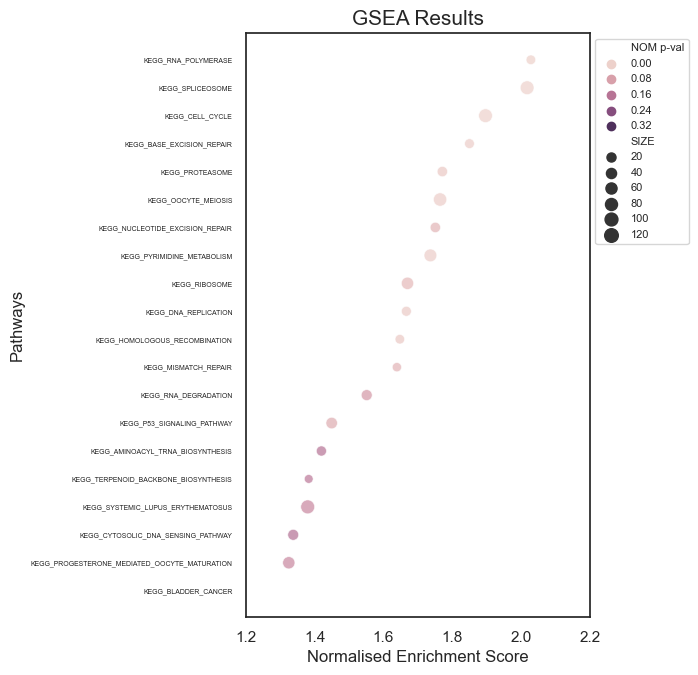

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

rows = ['KEGG_RNA_POLYMERASE',
'KEGG_SPLICEOSOME',
'KEGG_CELL_CYCLE',
'KEGG_BASE_EXCISION_REPAIR',
'KEGG_PROTEASOME',
'KEGG_OOCYTE_MEIOSIS',
'KEGG_NUCLEOTIDE_EXCISION_REPAIR',
'KEGG_PYRIMIDINE_METABOLISM',
'KEGG_RIBOSOME',
'KEGG_DNA_REPLICATION',
'KEGG_HOMOLOGOUS_RECOMBINATION',
'KEGG_MISMATCH_REPAIR',
'KEGG_RNA_DEGRADATION',
'KEGG_P53_SIGNALING_PATHWAY',
'KEGG_AMINOACYL_TRNA_BIOSYNTHESIS',
'KEGG_TERPENOID_BACKBONE_BIOSYNTHESIS',
'KEGG_SYSTEMIC_LUPUS_ERYTHEMATOSUS',
'KEGG_CYTOSOLIC_DNA_SENSING_PATHWAY',
'KEGG_PROGESTERONE_MEDIATED_OOCYTE_MATURATION',
'KEGG_BLADDER_CANCER']

df = pd.read_csv("./data/gsea_report_for_low_1684386912385.csv")
df = df[df["Pathways"].isin(rows)]

# use the scatterplot function
sns.set_style(style='white')
# sns.set(rc = {'figure.figsize':(8,8)})
sns.scatterplot(data=df, x="Normalised Enrichment Score", y="Pathways", size="SIZE", hue="NOM p-val",alpha= 0.7, sizes=(40, 100))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=8)

# show the graph

plt.xlim(1.2,2.2)
plt.subplots_adjust(bottom=0.15)
plt.subplots_adjust(left=0.37, right=0.8)
plt.title("GSEA Results", fontsize= 15)
plt.tick_params(axis='y', labelsize=5)
plt.savefig('GSEA.jpeg',dpi=200)
plt.show()

In [11]:
df.head()


,Pathways,GS<br> follow link to MSigDB,GS DETAILS,SIZE,ES,Normalised Enrichment Score,NOM p-val,FDR q-val,FWER p-val,RANK AT MAX,LEADING EDGE
0,KEGG_RNA_POLYMERASE,KEGG_RNA_POLYMERASE,Details ...,29,0.607062,2.028663,0.004049,0.041988,0.045,5108,"tags=59%, list=25%, signal=78%"
1,KEGG_SPLICEOSOME,KEGG_SPLICEOSOME,Details ...,124,0.559397,2.017710,0.000000,0.025033,0.053,5546,"tags=56%, list=27%, signal=77%"
2,KEGG_CELL_CYCLE,KEGG_CELL_CYCLE,Details ...,124,0.638197,1.896745,0.000000,0.054877,0.147,1694,"tags=35%, list=8%, signal=38%"
3,KEGG_BASE_EXCISION_REPAIR,KEGG_BASE_EXCISION_REPAIR,Details ...,33,0.633603,1.850096,0.006211,0.060847,0.202,5377,"tags=70%, list=27%, signal=95%"
4,KEGG_PROTEASOME,KEGG_PROTEASOME,Details ...,44,0.626570,1.771356,0.015504,0.099707,0.356,7391,"tags=95%, list=37%, signal=150%"
